# Lab: Titanic Survival Exploration with Decision Trees

## Getting Started
In this lab, you will see how decision trees work by implementing a decision tree in sklearn.

We'll start by loading the dataset and displaying some of its rows.

In [6]:
# Import libraries necessary for this project
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty display for notebooks
%matplotlib inline

# Set a random seed
import random
random.seed(42)

# Load the dataset
in_file = 'titanic_data.csv'
full_data = pd.read_csv(in_file)

# load kaggle set that we will test on
kaggle_test_file = 'test.csv'
kaggle_test_set = pd.read_csv(kaggle_test_file)

# Print the first few entries of the RMS Titanic data
display(full_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
display(kaggle_test_set.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Recall that these are the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Since we're interested in the outcome of survival for each passenger or crew member, we can remove the **Survived** feature from this dataset and store it as its own separate variable `outcomes`. We will use these outcomes as our prediction targets.  
Run the code cell below to remove **Survived** as a feature of the dataset and store it in `outcomes`.

In [8]:
# Store the 'Survived' feature in a new variable and remove it from the dataset
outcomes = full_data['Survived']
features_raw = full_data.drop('Survived', axis = 1)

# Show the new dataset with 'Survived' removed
display(features_raw.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The very same sample of the RMS Titanic data now shows the **Survived** feature removed from the DataFrame. Note that `data` (the passenger data) and `outcomes` (the outcomes of survival) are now *paired*. That means for any passenger `data.loc[i]`, they have the survival outcome `outcomes[i]`.

## Preprocessing the data

Now, let's do some data preprocessing. First, we'll one-hot encode the features.

In [10]:
features = features_raw.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
features = pd.get_dummies(features)

# do the same transformations on the kaggle test set
kaggle_test_set_dropped = kaggle_test_set.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
features_kaggle = pd.get_dummies(kaggle_test_set_dropped)

And now we'll fill in any blanks with zeroes.

In [11]:
features = features.fillna(0.0)
features_kaggle = features_kaggle.fillna(0.0) # do same transformations to kaggle
display(features.head())

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


## (TODO) Training the model

Now we're ready to train a model in sklearn. First, let's split the data into training and testing sets. Then we'll train the model on the training set.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2, random_state=42)

**NOTE**: Changing the `random_state` from `42` to `1` takes the 'test' accuracy from `~0.87` to `~0.78`. Seems like this decision tree is highly unstable. Also, if I upload the model that scores `~0.87` to kaggle, it only scores around a `~0.79`.

In [26]:
len(y_test)

179

In [27]:
# X_train

# Exerise: Improving the model

Ok, high training accuracy and a lower testing accuracy. We may be overfitting a bit.

So now it's your turn to shine! Train a new model, and try to specify some parameters in order to improve the testing accuracy, such as:
- `max_depth`
- `min_samples_leaf`
- `min_samples_split`

You can use your intuition, trial and error, or even better, feel free to use Grid Search!

**Challenge:** Try to get to 85% accuracy on the testing set. If you'd like a hint, take a look at the solutions notebook in this same folder.

In [28]:
# Import the classifier from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# Training the model
model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=6, min_samples_split=10)
model.fit(X_train, y_train)

# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculating accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.8623595505617978
The test accuracy is 0.8715083798882681


{'whiskers': [<matplotlib.lines.Line2D at 0x116078b70>,
 'caps': [<matplotlib.lines.Line2D at 0x116081470>,
 'boxes': [<matplotlib.lines.Line2D at 0x116078a20>],
 'medians': [<matplotlib.lines.Line2D at 0x116081cc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x116087128>],
 'means': []}

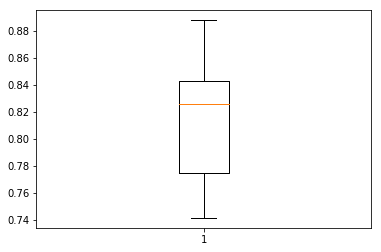

In [30]:
from sklearn.model_selection import cross_val_score
scores =  cross_val_score(model, features, outcomes, scoring='accuracy', cv=10)
scores
plt.boxplot(scores)

# Refit Final Model on ALL data

In [31]:
# Training the model
model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=6, min_samples_split=10)
model.fit(features, outcomes)

# Making predictions
y_train_pred = model.predict(features)

# Calculating accuracies
train_accuracy = accuracy_score(outcomes, y_train_pred)

print('The training accuracy is', train_accuracy)

The training accuracy is 0.8462401795735129


In [32]:
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [33]:
y_test_kaggle = model.predict(features_kaggle)

In [34]:
test_set_predictions = pd.DataFrame({'PassengerId': kaggle_test_set['PassengerId'], 'Survived': y_test_kaggle})
#test_set_predictions

In [35]:
test_set_predictions.to_csv('test_predictions.csv', index=False)